In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU, Bidirectional, LSTM
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
import keras

In [8]:
# Read data from csv file, consider column 'date' as index and parse it into date object
dataset = pd.read_csv('../input/historical_stock_prices.csv', index_col='date', parse_dates=['date'])

In [9]:
trainSet = dataset['2017-06-01':'2017-12-31'].sort_values(by=['ticker','date'])
testSet = dataset['2018':].sort_values(by=['ticker','date'])

In [10]:
symbols = trainSet.ticker.unique()

In [11]:
timesteps = 60
def make_samples(data, s, is_test):
    stop_append = {}
    for i in prediction_intervals:
        stop_append.update({i:False}) 
    l = len(data)
    for i in range(timesteps, l):
        x = data[i-timesteps: i, 0]
        for j in stop_append:
            if not stop_append[j]:
                if i+j-1 < l:
                    k = data[i+j-1,0]
                    if is_test:
                        test_set[s]['X'][j].append(x)
                        test_set[s]['Y'][j].append(k)
                    else:
                        train_set[s]['X'][j].append(x)
                        train_set[s]['Y'][j].append(k)
                    if k == data[l-1,0]:
                        stop_append[j] =True

In [12]:
test_set = {}
train_set = {}
scaler = {}
prediction_intervals = [1,3,5,10]
for s in symbols:
    # normalize data
    sc = MinMaxScaler(feature_range=(0,1))     
    train_stock = trainSet.loc[trainSet['ticker'] == s][['adj_close']].values
    test_stock = testSet.loc[testSet['ticker'] == s][['adj_close']].values
    sc.partial_fit(train_stock)
    if len(test_stock):
        sc.partial_fit(test_stock)
        test_stock_scaled = sc.transform(test_stock)
    train_stock_scaled = sc.transform(train_stock)
    scaler[s] = sc
    
    # Define train_set test_set
    train_set.update({s:{
        'X':{},
        'Y':{}
    }})
    test_set.update({s:{
        'X':{},
        'Y':{}
    }})
    for i in prediction_intervals:
        train_set[s]['X'][i] = []
        train_set[s]['Y'][i] = []
        if len(test_stock):
            test_set[s]['X'][i] = []
            test_set[s]['Y'][i] = []
    if len(test_stock):
        make_samples(test_stock_scaled, s, is_test = True)
    make_samples(train_stock_scaled, s, is_test = False)

In [13]:
# Convert into numpy array
for s in train_set:
    for i in train_set[s]['X']:
        x_train = train_set[s]['X'][i]
        y_train = train_set[s]['Y'][i]
        train_set[s]['X'][i] = np.array(x_train)
        train_set[s]['Y'][i] = np.array(y_train)
    for i in test_set[s]['X']:
        x_test = test_set[s]['X'][i]
        y_test = test_set[s]['Y'][i]
        test_set[s]['X'][i] = np.array(x_test)
        test_set[s]['Y'][i] = np.array(y_test)

In [ ]:
# np.save('train_set.npy', train_set) 
# np.save('test_set.npy', test_set)

In [14]:
es = keras.callbacks.EarlyStopping(monitor='val_loss',patience=2, mode='min')

In [15]:
def make_gru_network():
    regressorGRU = Sequential()

    regressorGRU.add(GRU(units=30, return_sequences=False, input_shape=(60,1), activation='tanh'))
    regressorGRU.add(Dropout(0.3))


    regressorGRU.add(Dense(units=1))
    return regressorGRU

In [16]:
model = {}
model_history = {}
for i in [1,10]:
    model[i] = make_gru_network()
    model[i].compile(optimizer='rmsprop', loss='mean_squared_error')
    n_epoch = 100
    x_train = []
    y_train = []
    for s in train_set:
        for j in train_set[s]['X'][i]:
            x_train.append(j)
        for j in train_set[s]['Y'][i]:
            y_train.append(j)
    X_train, Y_train = np.array(x_train), np.array(y_train)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

    print('Fitting prediction interval {}  model'.format(i))
    model_history[i] = model[i].fit(X_train, Y_train, epochs = n_epoch, batch_size = 6000, 
                                    validation_split = 0.3,callbacks=[es])

Fitting prediction interval 1  model
Train on 292826 samples, validate on 125498 samples
Epoch 1/100
292826/292826 [==============================] - 9s 32us/step - loss: 0.0383 - val_loss: 0.0048
Epoch 2/100
292826/292826 [==============================] - 5s 19us/step - loss: 0.0100 - val_loss: 0.0034
Epoch 3/100
292826/292826 [==============================] - 5s 19us/step - loss: 0.0074 - val_loss: 0.0031
Epoch 4/100
292826/292826 [==============================] - 5s 19us/step - loss: 0.0064 - val_loss: 0.0026
Epoch 5/100
292826/292826 [==============================] - 5s 19us/step - loss: 0.0057 - val_loss: 0.0027
Epoch 6/100
292826/292826 [==============================] - 5s 19us/step - loss: 0.0052 - val_loss: 0.0024
Epoch 7/100
292826/292826 [==============================] - 5s 18us/step - loss: 0.0049 - val_loss: 0.0024
Epoch 8/100
292826/292826 [==============================] - 5s 19us/step - loss: 0.0046 - val_loss: 0.0021
Epoch 9/100
292826/292826 [====================

## Loss Graph

In [18]:
# for i in [1,10]:
#     plt.plot(model_history[i].history['loss'])
# plt.title('Model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['Interval 1', 'Interval 3', 'Interval 5', 'Interval 10'], loc='upper right')
# plt.show()

In [19]:
# for i in [1,10]:
#     plt.plot(model_history[i].history['val_loss'])
# plt.title('Model Validation loss')
# plt.ylabel('val_loss')
# plt.xlabel('epoch')
# plt.legend(['Interval 1', 'Interval 3', 'Interval 5', 'Interval 10'], loc='upper right')
# plt.show()

## Helper function ##

In [20]:
# Calculate Mean squared_error #
def return_mse(test,predicted):
    mse = mean_squared_error(test, predicted)
    return mse

In [21]:
# Plotting graph
def plotting_graph(y_test, y_pred, ticker, des):
    plt.plot(y_test, color='green', label='Actual adj_close value')
    plt.plot(y_pred, color='red', label='Predicted adj_close value')
    plt.title('Prediction of {} on {}'.format(ticker, des))
    plt.xlabel('Time steps')
    plt.ylabel('adj_close value')
    plt.legend()
    plt.show()

# Evaluate model #

In [22]:

def make_prediction(data, s, i):
    sc = scaler[s]
    mse = 0
    # Define X_test
    x_test = data[s]['X'][i]
    X_test = np.array(x_test)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    # Define y_true
    y_test = data[s]['Y'][i]
    Y_test = np.array(y_test)
    Y_test = Y_test.reshape(-1,1)
    y_true = sc.inverse_transform(Y_test)

    # Predicting
    result = model[i].predict(X_test)
    y_pred = sc.inverse_transform(result)

    # Calculate MSE
    mse = return_mse(y_true, y_pred)
    return y_true, y_pred, mse

## Predicting on Test Set

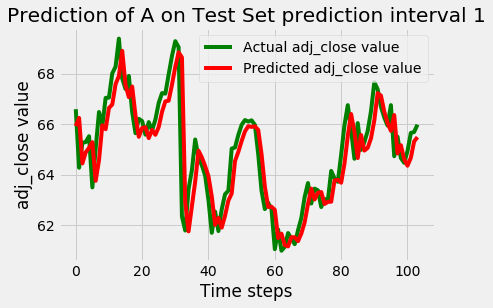

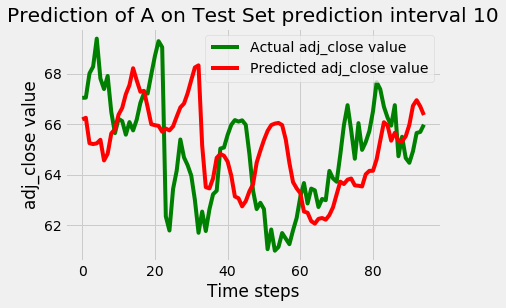

In [43]:
mse_val = {}
for i in [1,10]:
    # Predicting
    s = 'A'
    y_true, y_pred, mse = make_prediction(test_set, s, i)
    mse_val[i] = mse
    # Plotting graph
    plotting_graph(y_true, y_pred, s, 'Test Set prediction interval {}'.format(i))

In [44]:
for i in mse_val:
    print('Test Set -> MSE of {} inveral {}: {}'.format(s, i, mse_val[i]))

Test Set -> MSE of A inveral 1: 1.142470577256555
Test Set -> MSE of A inveral 10: 5.587091291261583
